# Part 2: Bike Share Feature Engineering

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [27]:
df= pd.read_csv('../Bike share data (atemp-weather fix).csv')

In [28]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


From the datetime column I wish to extract the day of the week, the hour, the month and the year.
The impact month has on count is probably already accounted for by season.

In [29]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.strftime('%H')
df['month'] = df['datetime'].dt.strftime('%m')
df['day'] = df['datetime'].dt.strftime('%a')
df['year'] = df['datetime'].dt.strftime('%Y')

### Exploration of time on 'count'

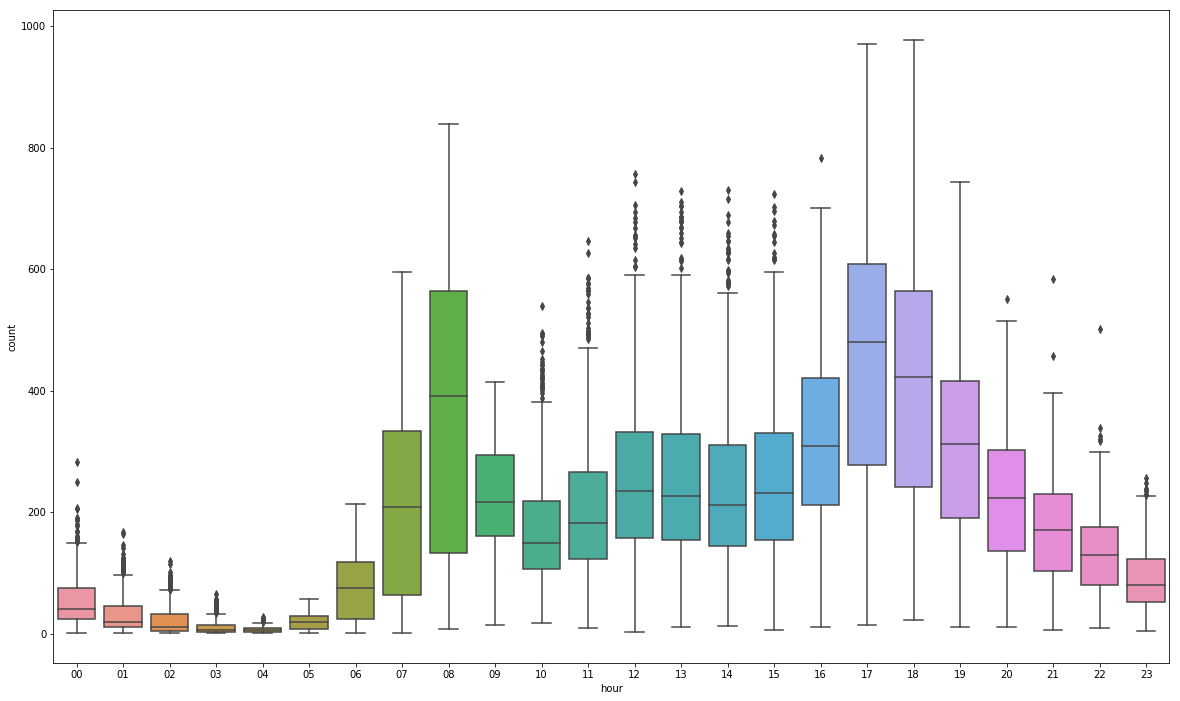

In [30]:
#hour and count
plt.figure(figsize=(20,12)); sns.boxplot(x='hour', y = 'count',data=df)

This shows that there is most demand for when many people are going to and from work (7-8 and 17-19)
Perhaps demand is very different for non working days.

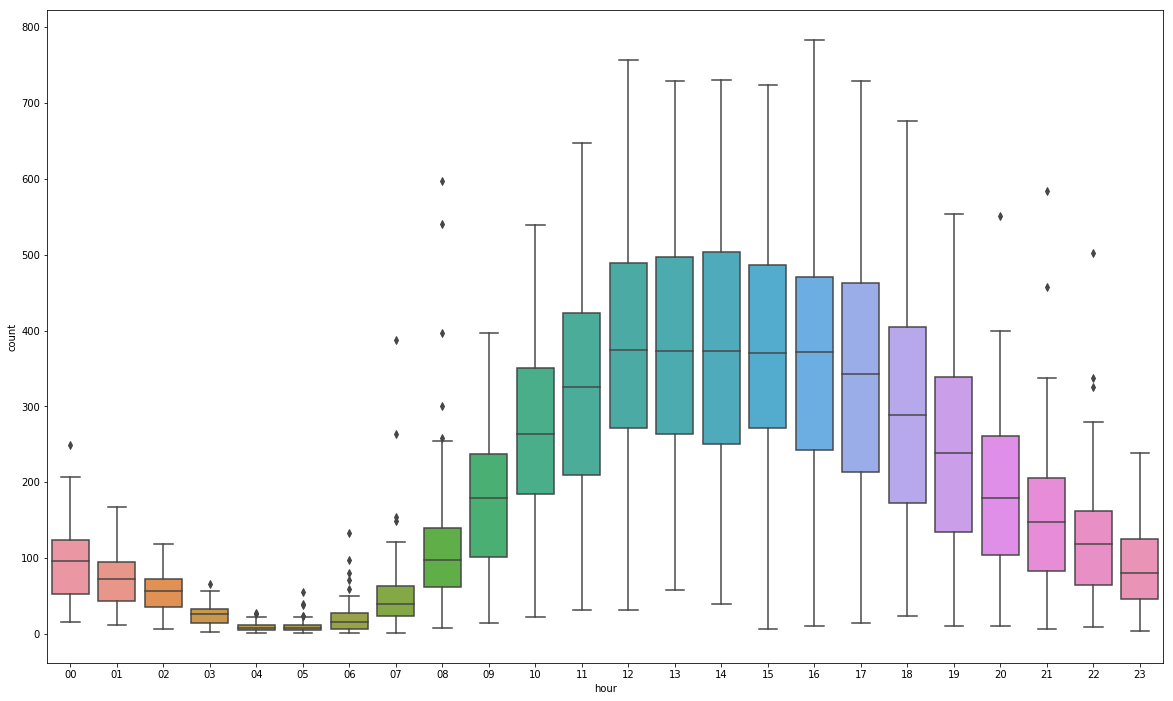

In [31]:
plt.figure(figsize=(20,12)); sns.boxplot(x='hour', y = 'count',data=df[df['workingday'] == 0])

Demand is very different! most of the demand for bikes is in the middle of the day.
This clearly indicates that we will need interaction terms in our model.

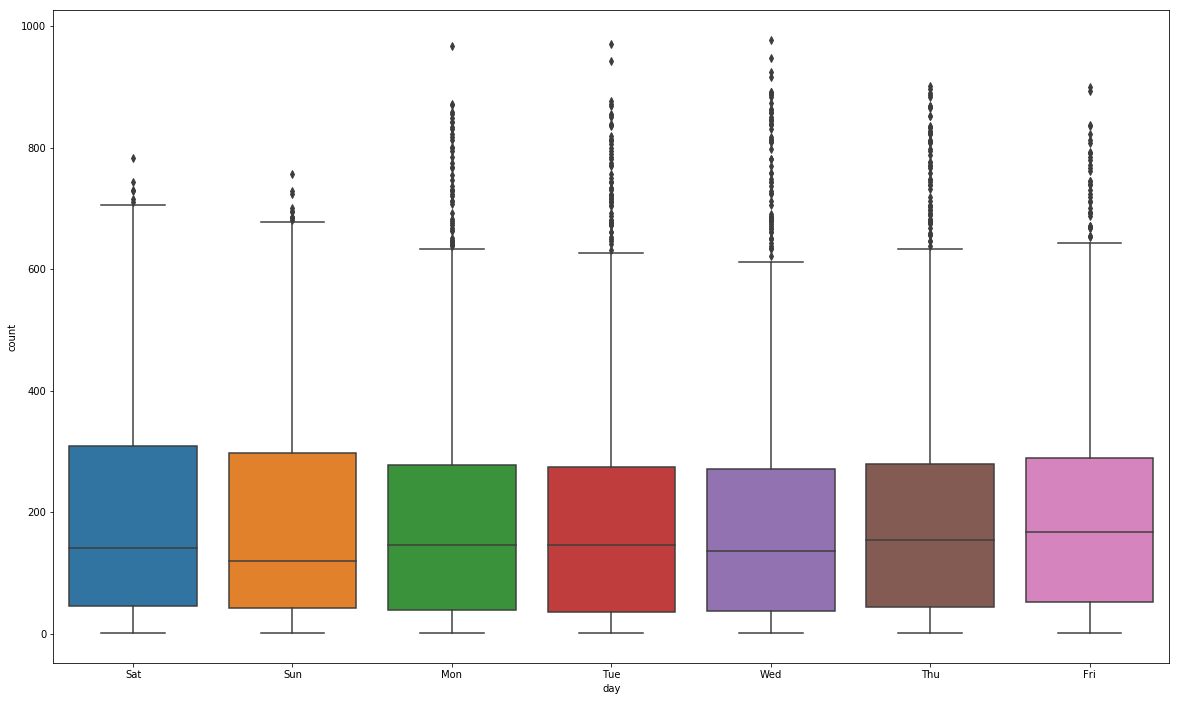

In [32]:
#day and count
plt.figure(figsize=(20,12)); sns.boxplot(x='day', y = 'count',data=df)

There are not massive differences between the days. Sunday has the lowest median, Friday has the greatest.

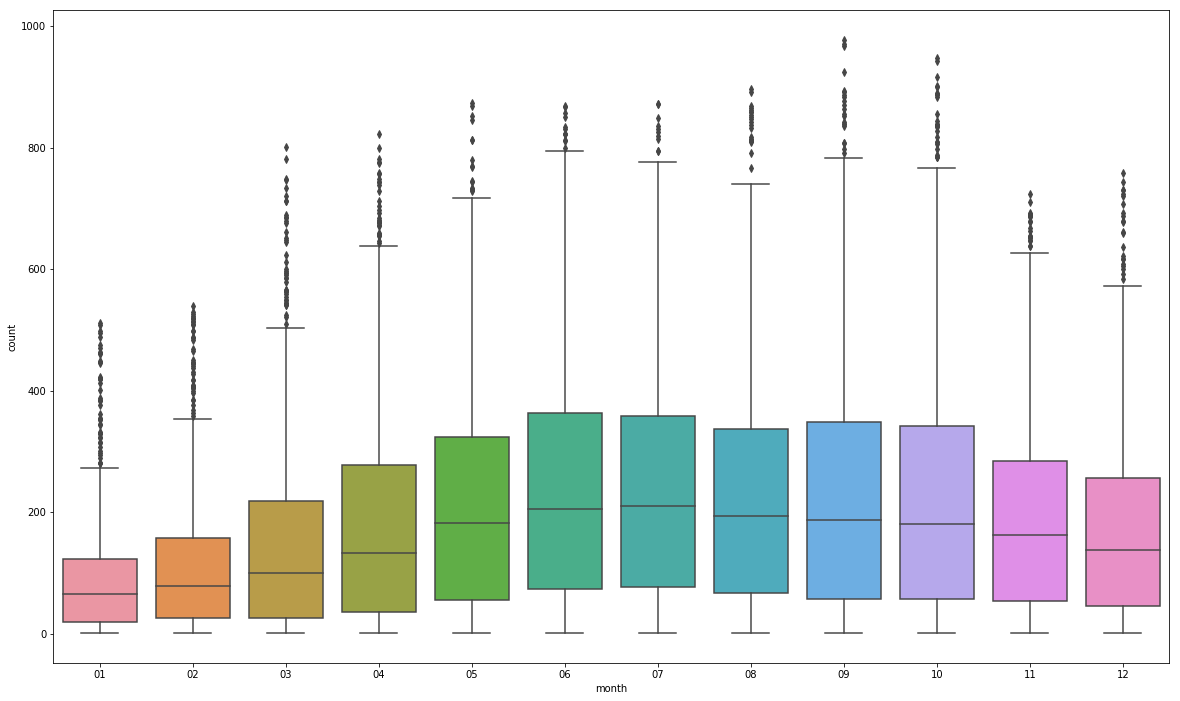

In [33]:
#month and count
plt.figure(figsize=(20,12)); sns.boxplot(x='month', y = 'count',data=df)

Shows same trend as 'season'

### Turning categories into dummy variables

In [34]:
#Separate targets from features
dfTargets = df[['count', 'casual', 'registered']]
dfFeatures = df.drop(['datetime','count', 'casual', 'registered'], axis = 1)

In [35]:
#make dummy variables from categorical data 
#(first var will be dropped (as its already covered by model intercept) - not strictly necessary if the model to be used has L1 regularisation)
#holiday/workingday already in dummy format
toDummy = dfFeatures.drop(['holiday', 'workingday','temp', 'atemp','humidity', 'windspeed'], axis =1)
dum = pd.get_dummies(toDummy.astype(object), drop_first=True)

In [36]:
#new features DF that has the dummy variables
dfFeatures2 = pd.concat((dfFeatures[['holiday', 'workingday','temp', 'atemp','humidity', 'windspeed']],dum), axis=1)

### Reduce temp and atemp to a single feature using PCA

In [37]:
#first temp must be scaled 
from sklearn.preprocessing import StandardScaler
tempScaler = StandardScaler()
tempScaler.fit_transform(df[['atemp', 'temp']])
tempScaled = tempScaler.fit_transform(df[['atemp', 'temp']])

In [38]:
#apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
tempPCA = pca.fit_transform(tempScaled)
print('Variance explained by the first component: {}'.format(round(pca.explained_variance_ratio_[0],2)))

Variance explained by the first component: 1.0


99% of variance within atemp and temp is within the first component so we'll just keep that one.
there is no need to have two (closely related) temp variables. Reducing them to one feature should limit the impact noise will have on the model.
We could do PCA on other features but it would come at the cost of interpretability. This component is still very easy to understand (hot vs cold etc.)

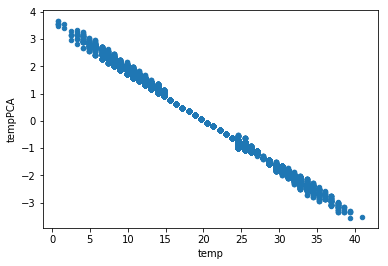

In [39]:
tempPCA = tempPCA[:,0]
dfFeatures2['tempPCA'] = tempPCA
dfFeatures2.plot.scatter('temp', 'tempPCA')

ah the PC is not correctly orientated, lets try that again

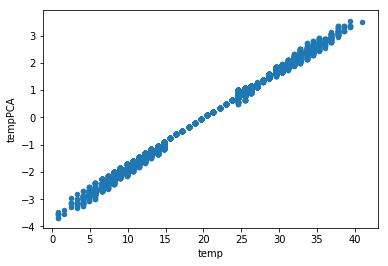

In [40]:
dfFeatures2['tempPCA'] = -tempPCA
dfFeatures2.plot.scatter('temp', 'tempPCA')

In [41]:
#drop the unneeded temp variables
dfFeatures2 = dfFeatures2.drop(['temp', 'atemp'], axis =1)

### Make new feature DF derived from polynomials to capture feature interactions.

Its quite likely that there are interactions between features. For example peak times during a workday are 8am and 5pm. This is not so for nonworking days. We can use sklearn's PolynomialFeatures to derive these interactions.

However interactions must be derived from data that has been scaled (mean must be zero) so that collinearity between the orginal features and the interactions is nullified. The code below is to demonstrate interactions. The resulting features will not be used in the modelling process. Rather the interactions will be derived in the model pipelines after the data has been scaled.

In [42]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
dfFeatures3 = poly.fit_transform(dfFeatures2)

We've lost column names and need to derive them again (poly.get_feature_names() is insufficient)

In [43]:
newCols = list(dfFeatures2)
spent = []
for i in dfFeatures2.columns:
    for j in dfFeatures2.columns:
        if j in spent:
            continue
        elif i == j:
            continue
        else:
            col = i + 'X' + j
            
        newCols.append(col)
    spent.append(i)
    
list(zip(newCols, poly.get_feature_names()))[:55]

[('holiday', 'x0'),
 ('workingday', 'x1'),
 ('humidity', 'x2'),
 ('windspeed', 'x3'),
 ('season_2', 'x4'),
 ('season_3', 'x5'),
 ('season_4', 'x6'),
 ('weather_2', 'x7'),
 ('weather_3', 'x8'),
 ('hour_01', 'x9'),
 ('hour_02', 'x10'),
 ('hour_03', 'x11'),
 ('hour_04', 'x12'),
 ('hour_05', 'x13'),
 ('hour_06', 'x14'),
 ('hour_07', 'x15'),
 ('hour_08', 'x16'),
 ('hour_09', 'x17'),
 ('hour_10', 'x18'),
 ('hour_11', 'x19'),
 ('hour_12', 'x20'),
 ('hour_13', 'x21'),
 ('hour_14', 'x22'),
 ('hour_15', 'x23'),
 ('hour_16', 'x24'),
 ('hour_17', 'x25'),
 ('hour_18', 'x26'),
 ('hour_19', 'x27'),
 ('hour_20', 'x28'),
 ('hour_21', 'x29'),
 ('hour_22', 'x30'),
 ('hour_23', 'x31'),
 ('month_02', 'x32'),
 ('month_03', 'x33'),
 ('month_04', 'x34'),
 ('month_05', 'x35'),
 ('month_06', 'x36'),
 ('month_07', 'x37'),
 ('month_08', 'x38'),
 ('month_09', 'x39'),
 ('month_10', 'x40'),
 ('month_11', 'x41'),
 ('month_12', 'x42'),
 ('day_Mon', 'x43'),
 ('day_Sat', 'x44'),
 ('day_Sun', 'x45'),
 ('day_Thu', 'x46'),

Everything lines up!

In [44]:
dfFeatures3 = pd.DataFrame(data = dfFeatures3, columns = newCols)
print('Feature set shape: {}'.format(dfFeatures3.shape))

Feature set shape: (10886, 1326)


There are now 1325 features. These have been derived from parsing the date column, making dummy variables from category columns, PCA on temperature and by making interactions. (Note that the interactions will be recalucated in the model pipelines so that they can be derived from scaled data).

### Deterimine if the target needs to be transformed

Linear Regression models assume normally distributed residuals. We may have to transform the target variable for that to be the case.

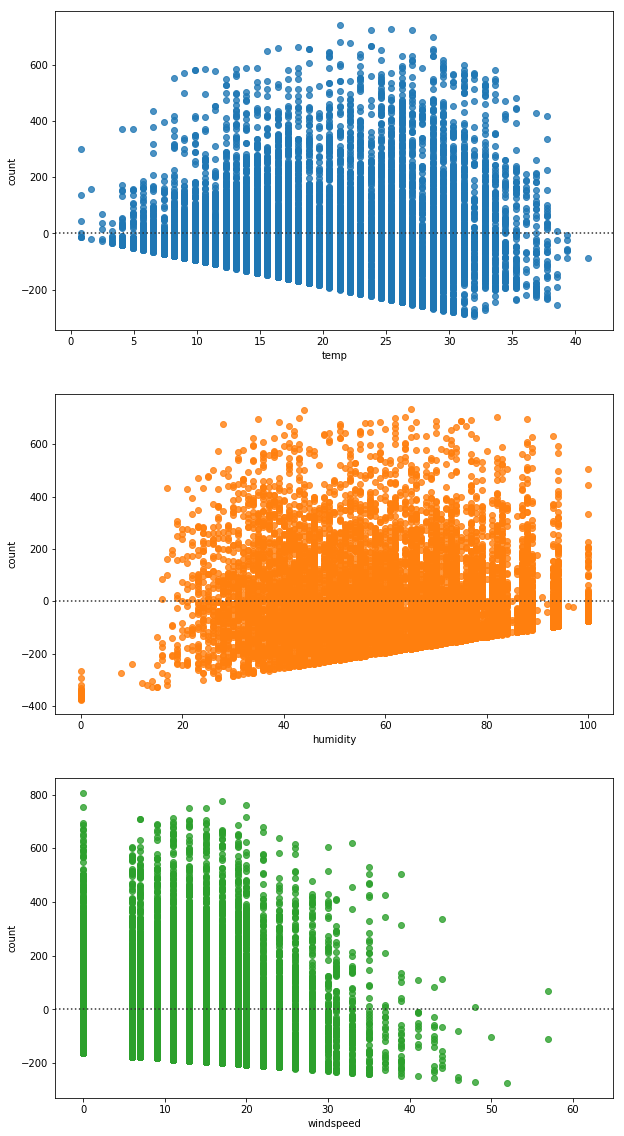

In [45]:
dfResid = df[['temp','humidity','windspeed', 'count']].copy()
fig, axes = plt.subplots(3,1, figsize=(10, 20))
for i, ax in enumerate(fig.axes):
    if i < 3:
        sns.residplot(x=dfResid.columns[i], y = 'count', data=dfResid, ax=ax)

These residuals are not normal. A log transformation on 'count' may improve things.

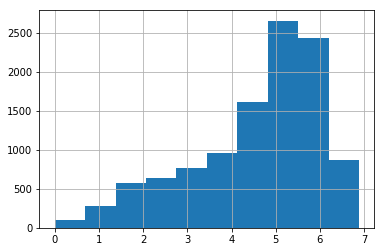

In [46]:
dfResid['log(count)'] = np.log(dfResid['count'])
dfResid['log(count)'].hist()

That did not sufficiently normalise the data, lets try something else (Box-Cox transformation)

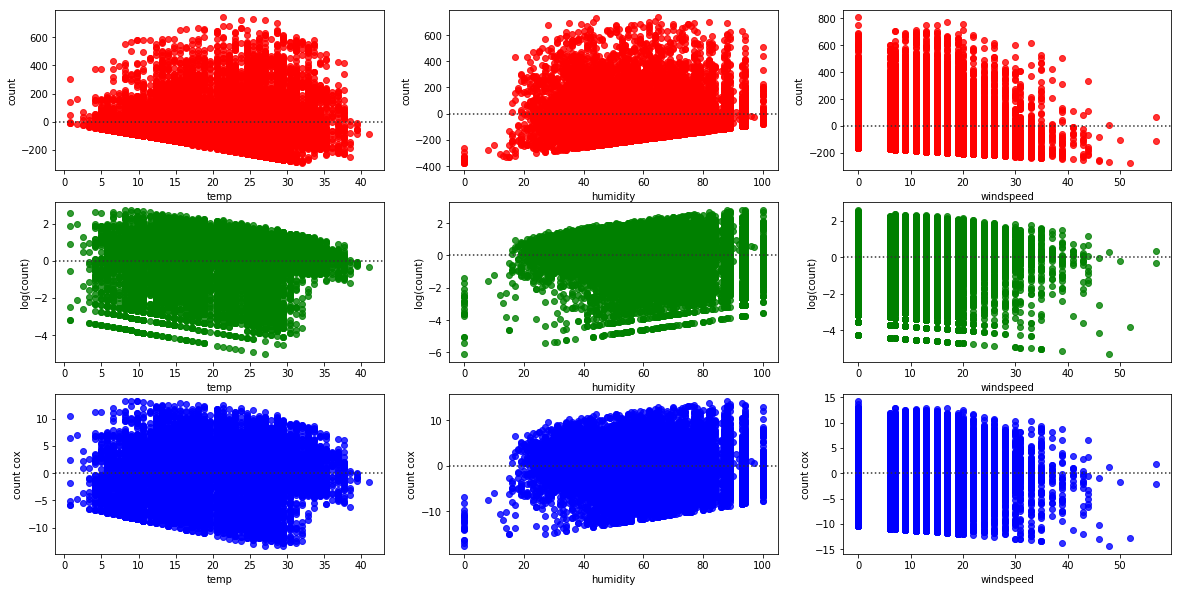

In [47]:
from scipy import stats
dfResid['count cox']=stats.boxcox(dfResid['count'])[0]

fig, axes = plt.subplots(3,3, figsize=(20,10))
for i, ax in enumerate(fig.axes):
    if i < 3:
        sns.residplot(x=dfResid.columns[i], y = 'count', data=dfResid, ax=ax, color ='r')
    if 2 < i < 6:
        sns.residplot(x=dfResid.columns[i-3], y = 'log(count)', data=dfResid, ax=ax, color ='g')
    if 5 < i < 9:
        sns.residplot(x=dfResid.columns[i-6], y = 'count cox', data=dfResid, ax=ax, color ='b')

Target variable cannot be so easily normalised. This is probably due to it being count data.
Something like Poisson regression would be ideal for modelling this data. However its not as robust as some of the more advanced linear regression techniques like Ridge and Lasso, especially not when dealing with a large feature set like ours. 
The above charts do at least show that some transformation is better than no transformation. Box cox looks best.

In [48]:
#Box cox transform target variables (+1)
for col in dfTargets.columns:
    dfTargets[col + ' cox'] = stats.boxcox(dfTargets[col]+1)[0]

In [49]:
#Export adapted dataset for Part 3: Bike Share Modelling
#pd.concat((dfFeatures2,dfTargets), axis=1).to_csv('../Bike share data (Featurised).csv', index=False)